In [2]:
#%pip install -U ipykernel
import urllib.request
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
df_price = pd.read_excel("elspotprices - Jan-Dec-2021.xlsx")
df_meter = pd.read_excel("Meterdata Jan-Dec-2021.xlsx")
df_CO2_Jan2Mar = pd.read_excel("co2emis Jan-Mar.xlsx")
df_CO2_Mar2Aug = pd.read_excel("co2emis Mar-Aug.xlsx")
df_CO2_Aug2Jan = pd.read_excel("co2emis Aug-Jan.xlsx")



In [4]:
df_CO2_2021 = pd.concat([df_CO2_Aug2Jan,df_CO2_Mar2Aug, df_CO2_Jan2Mar])
df_CO2_2021 = df_CO2_2021[df_CO2_2021.PriceArea != 'DK1'].drop(columns=['Minutes5DK']).loc[::-1].reset_index(drop=True)
df_CO2_2021.set_index("Minutes5UTC")
df_CO2_2021.index = pd.to_datetime(df_CO2_2021['Minutes5UTC'])
#df.info()
#df_CO2_2021.resample("60T", level=0, label='left', closed='left').CO2Emission.sum()
idx = pd.date_range('1/1/2021', periods=8760, freq='H')
df_CO2_2021_hourly = pd.Series.to_frame(df_CO2_2021.resample("H", level=0).CO2Emission.mean()).fillna(0)
df_CO2_2021_hourly.index = idx




In [5]:
df_CO2_2021_hourly_min = pd.Series.to_frame(df_CO2_2021_hourly.resample("D", level=0).CO2Emission.min())
df_CO2_2021_hourly_min.rename(columns={'CO2Emission':'CO2EmissionMin'}, index={'One' : 'Row_1'}, inplace=True)

In [6]:
df_price['TimeStamp']=df_price['HourUTC'].astype(str)
df_price = df_price.drop(df_price[df_price.PriceArea != "DK2"].index).drop(columns=["SpotPriceEUR", "HourDK", "HourUTC"])
df_price['TimeStamp'] = df_price['TimeStamp'].apply(lambda x: x.replace('+00:00', ''))
df_price['TimeStamp'] = df_price['TimeStamp'].apply(lambda x: x.replace('T', ' '))

In [7]:
df_consumption = df_meter.drop(df_meter[df_meter.MålepunktsID != 571313174111087437].index, inplace=False).drop(columns=["Til_dato", "Kvalitet", "Type"])
df_consumption['Fra_dato']=df_consumption['Fra_dato'].astype(str)

In [8]:
df_production = df_meter.drop(df_meter[df_meter.MålepunktsID != 571313179103037971].index, inplace=False).drop(columns=["Kvalitet", "Type", "Til_dato", "Måleenhed"])
df_production['Fra_dato']=df_production['Fra_dato'].astype(str)
df_production.rename(columns={'MålepunktsID':'ProductionID', 'Mængde':'Production'}, index={'One' : 'Row_1'}, inplace=True)

In [9]:

df_merged = df_consumption.set_index("Fra_dato").join(df_price.set_index("TimeStamp"))
df_merged = df_CO2_2021_hourly.join(df_merged).dropna(axis = 0)
df_merged.index = pd.to_datetime(df_merged.index)
#print(df_merged.info())

In [10]:
df_merged_production = df_production.set_index("Fra_dato").join(df_price.set_index("TimeStamp")).drop(columns=["PriceArea", "SpotPriceDKK"])
df_merged_production.index = pd.to_datetime(df_merged_production.index)

In [11]:
df_spot_price_min = pd.Series.to_frame(df_merged.resample("D", level=0).SpotPriceDKK.min())
df_spot_price_min.rename(columns={'SpotPriceDKK':'SpotPriceMinDKK'}, index={'One' : 'Row_1'}, inplace=True)

In [12]:
#df = pd.merge(df_merged, df_spot_price_min, how='outer', left_on= )
df_costs = df_merged.join(df_spot_price_min, how = 'outer').fillna(method="ffill")
#df = df_costs.join(df_production.set_index("Fra_dato"))
#df_costs = df_costs.join(df_production, lsuffix='index', rsuffix='Fra_dato', how='right')
#df = df_costs.join(df_production, how = 'left')

In [13]:
df_costs = df_costs.join(df_CO2_2021_hourly_min, how = 'outer').fillna(method="ffill")

In [14]:
df_costs = df_costs.join(df_merged_production, how='outer').fillna(0)

In [15]:
result = []
for time in df_costs.index:
    hour = (int(time.strftime("%H")))
    a = False
    if hour < 17 or 20 < hour:
        a = True
        result.append(30.54)
    else:
        result.append(76.51)       
df_costs["TarifDKK"] = result   
#print(df.head())

In [16]:
dk_vat = 1.25
df_costs["CostsNormal"] = (df_costs['Mængde'] * (df_costs['SpotPriceDKK']/1000 + df_costs["TarifDKK"]/100)*dk_vat)
df_costs["CostsBattery"] = ((df_costs['Mængde'] * (df_costs['SpotPriceMinDKK']/1000 + df_costs["TarifDKK"]/100)*dk_vat)
                            -(df_costs['Production']*df_costs["SpotPriceDKK"]/1000))

In [17]:
df_costs["CO2FootPrintNormal"] = (df_costs['Mængde'] * df_costs['CO2Emission'] - df_costs['Production']*df_costs['CO2Emission'])/1000
df_costs["CO2FootPrintBattery"] = (df_costs['Mængde'] * df_costs['CO2EmissionMin'] - df_costs['Production']*df_costs['CO2Emission'])/1000
df_dayCO2Normal = pd.Series.to_frame(df_costs.resample("D", level=0).CO2FootPrintNormal.sum())
df_dayCO2BAttery = pd.Series.to_frame(df_costs.resample("D", level=0).CO2FootPrintBattery.sum())
df_CO2Comparison = df_dayCO2Normal.join(df_dayCO2BAttery, how = 'inner')
df_CO2Comparison["CO2FootPrintDif"] = (df_CO2Comparison['CO2FootPrintNormal'] - df_CO2Comparison['CO2FootPrintBattery'])

In [18]:
#df_costs = df_merged.resample("D", level=0).Costs.sum()
df_dayCostsNormal = pd.Series.to_frame(df_costs.resample("D", level=0).CostsNormal.sum())
df_dayCostsBattery = pd.Series.to_frame(df_costs.resample("D", level=0).CostsBattery.sum())
df_costsComparison = df_dayCostsNormal.join(df_dayCostsBattery, how = 'inner')
df_costsComparison["CostsDifference"] = (df_costsComparison['CostsNormal'] - df_costsComparison['CostsBattery'])

In [19]:
print("Consumed kWh pr. year: ", int(df_costs.resample("Y", level=0).Mængde.sum()))
print("yearly costs without battery: ", int(df_costsComparison.resample("Y", level=0).CostsNormal.sum()))
print("yearly costs with battery: ", int(df_costsComparison.resample("Y", level=0).CostsBattery.sum()))
print("Saved DKK with Battery: ", int(df_costsComparison.resample("Y", level=0).CostsDifference.sum()))
print("CO2FootPrint without Battery: ", int(df_dayCO2Normal.resample("Y", level=0).CO2FootPrintNormal.sum()))
print("CO2FootPrint with Battery: ", int(df_dayCO2BAttery.resample("Y", level=0).CO2FootPrintBattery.sum()))

Consumed kWh pr. year:  10137
yearly costs without battery:  11906
yearly costs with battery:  7661
Saved DKK with Battery:  4245
CO2FootPrint without Battery:  1551
CO2FootPrint with Battery:  972


Text(0, 0.5, 'Costs[DKK]')

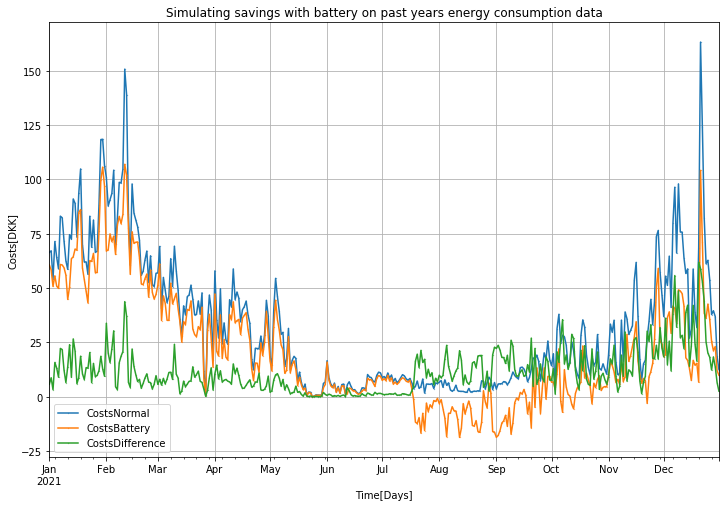

In [20]:
# Labelling the axes and setting
# a title
#plt.xlabel("Date")
#plt.ylabel("Costs[DKK]")
#plt.title("Sample Time Series Plot")
 
# plotting the "A" column alone
#plt.plot(df_costsComparison["CostsNormal"])
graph = df_costsComparison.plot(y=["CostsNormal","CostsBattery", "CostsDifference"], grid=True, subplots=False, figsize=(12, 8), marker='.', markersize=0.5, title='Simulating savings with battery on past years energy consumption data')
graph.set_xlabel("Time[Days]")
graph.set_ylabel("Costs[DKK]")

Text(0, 0.5, 'CO2[Kg]')

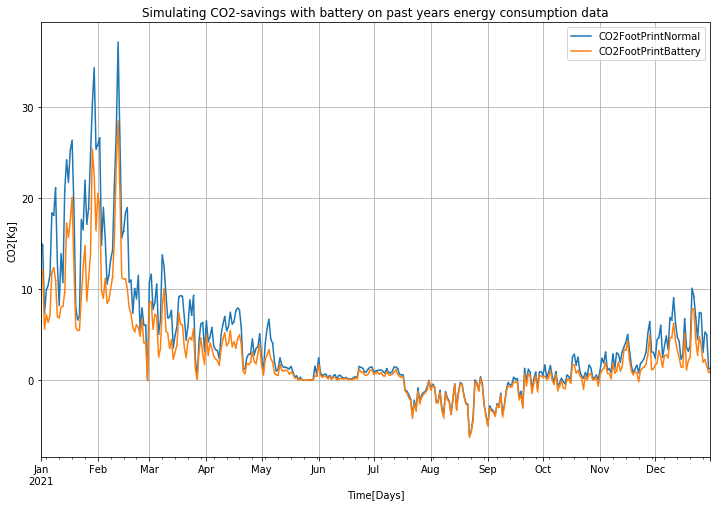

In [21]:
graph = df_CO2Comparison.plot(y=["CO2FootPrintNormal", "CO2FootPrintBattery"], grid=True, subplots=False, figsize=(12, 8), marker='.', markersize=0.5, title='Simulating CO2-savings with battery on past years energy consumption data')
graph.set_xlabel("Time[Days]")
graph.set_ylabel("CO2[Kg]")

In [22]:
import json
import urllib.request
url = 'https://api.energidataservice.dk/datastore_search?resource_id=co2emis&limit=5'
webURL = urllib.request.urlopen(url)
data = webURL.read()
print(data)
encoding = webURL.info().get_content_charset('utf-8')
JSON_object = json.loads(data.decode(encoding))

df = pd.DataFrame(JSON_object)


#fileobj = urllib.request.urlopen(url)
#print(fileobj.read())
#fileobj.info()

b'{"help": "https://api.energidataservice.dk/help_show?name=datastore_search", "success": true, "result": {"include_total": true, "resource_id": "b5a8e0bc-44af-49d7-bb57-8f968f96932d", "fields": [{"type": "int", "id": "_id"}, {"type": "timestamptz", "id": "Minutes5UTC"}, {"type": "timestamp", "id": "Minutes5DK"}, {"type": "text", "id": "PriceArea"}, {"type": "int4", "id": "CO2Emission"}], "records_format": "objects", "records": [{"_id":891,"Minutes5UTC":"2016-12-31T23:00:00+00:00","Minutes5DK":"2017-01-01T00:00:00","PriceArea":"DK1","CO2Emission":171},{"_id":892,"Minutes5UTC":"2016-12-31T23:05:00+00:00","Minutes5DK":"2017-01-01T00:05:00","PriceArea":"DK1","CO2Emission":163},{"_id":893,"Minutes5UTC":"2016-12-31T23:10:00+00:00","Minutes5DK":"2017-01-01T00:10:00","PriceArea":"DK1","CO2Emission":161},{"_id":894,"Minutes5UTC":"2016-12-31T23:15:00+00:00","Minutes5DK":"2017-01-01T00:15:00","PriceArea":"DK1","CO2Emission":160},{"_id":895,"Minutes5UTC":"2016-12-31T23:20:00+00:00","Minutes5DK":"

In [23]:
#url = 'https://api.energidataservice.dk/datastore_search?resource_id=elspotprices&limit=5'
#fileobj = urllib.request.urlopen(url)
#print(fileobj.read())

In [24]:
#import requests

#headers = {'content-type': 'application/json'}
#query = """
#{
#    elspotprices(limit: 10) {
#        HourUTC
#        HourDK
#        PriceArea
#        SpotPriceDKK
#        SpotPriceEUR
#    }
#}
#"""

#request = requests.post('https://data-api.energidataservice.dk/v1/graphql', json={'query': query}, headers=headers)

#print(request.json())